In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from IPython.display import display
import os
import imageio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms 
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.optim as optim

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
folders = ['dataA','dataB','dataC','dataD','dataE']
image_folder = 'CameraRGB'
mask_folder = 'CameraSeg'

In [3]:
data = []
base = '../input/lyft-udacity-challenge/'
for folder in folders:
    image_path = os.path.join(base,folder+"/"+folder, image_folder)
    mask_path = os.path.join(base,folder+"/"+folder, mask_folder)
    
    image_files = os.listdir(image_path)
    mask_files = os.listdir(mask_path)
    
    for image_file, mask_file in zip(image_files, mask_files):
        image_full_path = os.path.join(image_path, image_file)
        mask_full_path = os.path.join(mask_path, mask_file)
        
        data.append({'id': image_file.split('.')[0], 'imagepath': image_full_path, 'maskpath': mask_full_path})

df = pd.DataFrame(data)

In [34]:
class SDCDataSet(Dataset):
    def __init__(self,imgData):
        self.train = train
        self.imgData = imgData
        self.transform = A.Compose([
                            A.Resize(width=572, height=572),
                            A.HorizontalFlip(p=0.2),
                            A.RandomBrightnessContrast(p=0.2),
                            ToTensorV2(transpose_mask=True)
                        ])
    def __len__(self):
        return len(self.imgData)
    def __getitem__(self,idx):
        img = imageio.v3.imread(self.imgData.iloc[idx].imagepath)
        mask = imageio.v3.imread(self.imgData.iloc[idx].maskpath,mode="L")
        img = img.astype("float32")/255.0
        mask = mask.astype("float32") 
        transformed = self.transform(image=img, mask=mask)
        return transformed['image'],transformed['mask']  

In [35]:
train,test = train_test_split(df,test_size=0.2)

In [36]:
train_ds = SDCDataSet(train)
valid_ds = SDCDataSet(test)

In [37]:
train_dl = DataLoader(train_ds,batch_size=1)
valid_dl = DataLoader(valid_ds,batch_size=8)

In [39]:
device = torch.device('cuda:0')


In [43]:
class Unet(nn.Module):
    '''
    Unet model as proposed by paper 
    U-Net: Convolutional Networks for Biomedical Image Segmentation
    by Olaf Ronneberger, Philipp Fischer, and Thomas Brox
    code courtesy youtube video Abhishek Thakur
    '''
    def __init__(self):
        super(Unet,self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.down_conv1 = self.double_conv(3,64)
        self.down_conv2 = self.double_conv(64,128)
        self.down_conv3 = self.double_conv(128,256)
        self.down_conv4 = self.double_conv(256,512)
        self.down_conv5 = self.double_conv(512,1024)
        
        self.conv_trans1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv1 = self.double_conv(1024,512)
        
        self.conv_trans2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv2 = self.double_conv(512,256)
        
        self.conv_trans3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv3 = self.double_conv(256,128)
        
        self.conv_trans4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        self.up_conv4 = self.double_conv(128,64)
        
        self.out = nn.Conv2d(
            in_channels = 64,
            out_channels = 2,
            kernel_size = 1
        )


    def double_conv(self,in_c,out_c):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_c,out_channels=out_c,kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_c,out_channels=out_c,kernel_size=3),
            nn.ReLU(inplace=True),
        )
    
    def crop_tensor(self,tensor, target_tensor):
        '''
        Adjusting the shapes of layers to concatenate
        
        '''
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        # Assuming tensor size is larger than target size
        delta = tensor_size - target_size
        delta = delta // 2
        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]
    
    def forward(self,x):
        #contract path 
        x1 = self.down_conv1(x)
        x2 = self.max_pool_2x2(x1)
        
        x3 = self.down_conv2(x2)
        x4 = self.max_pool_2x2(x3)

        x5 = self.down_conv3(x4)
        x6 = self.max_pool_2x2(x5)

        x7 = self.down_conv4(x6)
        x8 = self.max_pool_2x2(x7)

        x9 = self.down_conv5(x8)
        
        #expand path 

        x= self.conv_trans1(x9)
        y = self.crop_tensor(x7,x)
        x = self.up_conv1(torch.cat([x,y],1))

        x= self.conv_trans2(x)
        y = self.crop_tensor(x5,x)
        x = self.up_conv2(torch.cat([x,y],1))

        x= self.conv_trans3(x)
        y = self.crop_tensor(x3,x)
        x = self.up_conv3(torch.cat([x,y],1))

        x= self.conv_trans4(x)
        y = self.crop_tensor(x1,x)
        x = self.up_conv4(torch.cat([x,y],1))

        x = self.out(x)

        return x


In [44]:
model = Unet()

In [68]:
img, mask = next(iter(train_dl))  
with torch.no_grad():
    predicted_mask = model(img)
predicted_mask.shape

torch.Size([1, 2, 388, 388])

In [74]:
predicted_mask_img = predicted_mask[0]
predicted_mask_img = predicted_mask[0].permute(1,2,0)
predicted_mask_img.shape

torch.Size([388, 388, 2])

TypeError: Invalid shape (388, 388, 2) for image data

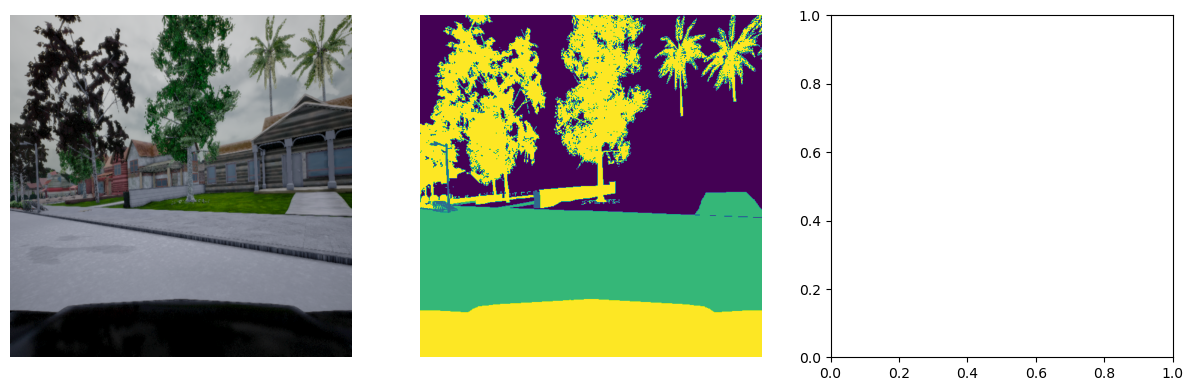

In [77]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img[0].permute(1,2,0))
#plt.title(f'Image {i+1} - Subfolder: {subfolder}')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask[0])  # Display mask in grayscale
#plt.title(f'Mask {i+1} - Subfolder: {subfolder}')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_img[:,:],cmap="gray")  # Display mask in grayscale
#plt.title(f'Mask {i+1} - Subfolder: {subfolder}')
plt.axis('off')

plt.show()

In [73]:
mask[0].shape

torch.Size([572, 572])

In [51]:
predicted_mask[0]

tensor([[[0.1073, 0.1067, 0.1053,  ..., 0.1053, 0.1060, 0.1054],
         [0.1065, 0.1075, 0.1052,  ..., 0.1058, 0.1051, 0.1048],
         [0.1067, 0.1075, 0.1060,  ..., 0.1054, 0.1042, 0.1034],
         ...,
         [0.1032, 0.1038, 0.1033,  ..., 0.1042, 0.1036, 0.1041],
         [0.1033, 0.1036, 0.1034,  ..., 0.1039, 0.1037, 0.1039],
         [0.1033, 0.1040, 0.1033,  ..., 0.1042, 0.1036, 0.1042]],

        [[0.1043, 0.1037, 0.1033,  ..., 0.1055, 0.1073, 0.1069],
         [0.1038, 0.1047, 0.1020,  ..., 0.1059, 0.1065, 0.1078],
         [0.1059, 0.1043, 0.1033,  ..., 0.1072, 0.1079, 0.1084],
         ...,
         [0.1061, 0.1063, 0.1060,  ..., 0.1061, 0.1058, 0.1060],
         [0.1066, 0.1067, 0.1066,  ..., 0.1064, 0.1064, 0.1065],
         [0.1060, 0.1063, 0.1060,  ..., 0.1061, 0.1058, 0.1061]]],
       grad_fn=<SelectBackward0>)

OSError: Cannot understand given URI: tensor([[[0.1073, 0.1067, 0.1053,  ..., 0.1053, 0.1060, 0....

In [ ]:
criterion = nn.CrossEntropyLoss()

# Define your optimizer
num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.OneCycleLR(optimizer,max_lr=0.001,epochs=num_epochs,steps_per_epoch=64)
num_epochs = 10
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_dl:
        optimizer.zero_grad()
        inputs=inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_dl)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = running_val_loss / len(valid_dl)
    val_accuracy = correct / total

    # Print average loss and accuracy for the epoch
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f} | Val Accuracy = {val_accuracy:.2%}")